In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [18]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/phonbank_longest.pickle')

In [19]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_phones,phones_list
0,"[4.499999713000699, 4.206104073935023, 3.99378...","[0.06032328910968175, 0.05988537201573046, 0.0...","[3.5645196909009105, 3.578147393253495, 3.5647...","[0.058223978940051484, 0.058108276914189086, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2643,1,1.0,Providence,/mnt/cube/tsainbur/Projects/github_repos/child...,543,aɪˈjɛˈiˈdædiˈdaʊ*ˈdaɪˈjaɪɡ*ˈaɪˈjɪ*ˈɡɑˈʌɪˈhwɛdɛ...
1,"[4.318715239977827, 3.967898421331192, 3.80850...","[0.05641612006563012, 0.05543521532093411, 0.0...","[3.5239373635306688, 3.5319140133478637, 3.535...","[0.054898144426552095, 0.055160822391381904, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2280,1,1.0,Providence,/mnt/cube/tsainbur/Projects/github_repos/child...,434,*dæˈdidæˈdiːˈɡaʊdæˈnɪnæˈnidiˈdiˈdeɪdiˈdejiˈtɪˈ...
2,"[3.2802134582860445, 3.11281825431207, 3.07556...","[0.10935063266969271, 0.10873530496867546, 0.1...","[3.007457874187586, 3.0063540152786707, 3.0049...","[0.1087829990408159, 0.10849721709870748, 0.10...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,627,1,1.0,Davis,/mnt/cube/tsainbur/Projects/github_repos/child...,325,ʌaːaːwawaaːwaʌːhʌːhʌːhʌːʌːʌːuhʌːʌːhæɪʌwæːɪooææ...


In [20]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [21]:
MI_DF_list = []
for [ac_low, ac_high] in age_cohorts:
    MI_DF_list.append(MI_DF[MI_DF.age_cohort_low == ac_low][:10])
MI_DF = pd.concat(MI_DF_list)

In [22]:
len(MI_DF)

60

### fit data

In [23]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [24]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan
    
    
    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


In [25]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[4.499999713000699, 4.206104073935023, 3.99378...","[0.06032328910968175, 0.05988537201573046, 0.0...","[3.5645196909009105, 3.578147393253495, 3.5647...","[0.058223978940051484, 0.058108276914189086, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2643,1,1.0,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.955456,0.976991,0.973716,-454.417625,-516.086703,-507.166929,pow_exp,"[-2.9173164195942825e-06, -4.38364605998745e-0...",219.0
1,"[4.318715239977827, 3.967898421331192, 3.80850...","[0.05641612006563012, 0.05543521532093411, 0.0...","[3.5239373635306688, 3.5319140133478637, 3.535...","[0.054898144426552095, 0.055160822391381904, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2280,1,1.0,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.908966,0.929166,0.926497,-307.372727,-325.774609,-326.838094,pow,"[1.301661780347569e-07, 1.9559606411236442e-07...",NaN
2,"[3.2802134582860445, 3.11281825431207, 3.07556...","[0.10935063266969271, 0.10873530496867546, 0.1...","[3.007457874187586, 3.0063540152786707, 3.0049...","[0.1087829990408159, 0.10849721709870748, 0.10...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,627,1,1.0,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.725905,0.732536,0.730711,-191.266541,-188.339077,-192.469408,pow,"[2.239644799036286e-06, 3.366511574965318e-06,...",NaN


In [26]:
MI_DF.columns

Index(['MI', 'MI_var', 'shuff_MI', 'shuff_MI_var', 'distances',
       'age_cohort_low', 'age_cohort_high', 'n_phones', 'n_unique_phones',
       'age', 'dataset', 'xml_loc', 'n_phones', 'phones_list', 'exp_results',
       'pow_results', 'concat_results', 'R2_exp', 'R2_concat', 'R2_power',
       'AICc_exp', 'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature',
       'min_peak'],
      dtype='object')

In [27]:
MI_DF.bestfitmodel.values

array(['pow_exp', 'pow', 'pow', 'pow_exp', 'exp', 'pow_exp', 'exp', 'exp',
       'pow', 'exp', 'pow', 'pow', 'pow_exp', 'pow_exp', 'pow_exp',
       'pow_exp', 'pow', 'pow_exp', 'exp', 'pow', 'pow_exp', 'exp',
       'pow_exp', 'pow', 'pow_exp', 'pow_exp', 'pow_exp', 'pow_exp',
       'pow', 'pow', 'pow_exp', 'exp', 'pow_exp', 'pow_exp', 'pow', 'pow',
       'pow_exp', 'pow', 'pow_exp', 'pow_exp', 'pow_exp', 'pow_exp',
       'pow', 'pow_exp', 'pow_exp', 'pow', 'exp', 'exp', 'pow', 'exp',
       'pow_exp', 'pow_exp', 'pow_exp', 'pow', 'pow', 'exp', 'pow_exp',
       'pow', 'pow', 'pow'], dtype=object)

### plot fits

In [28]:
from matplotlib import gridspec

0.5 1


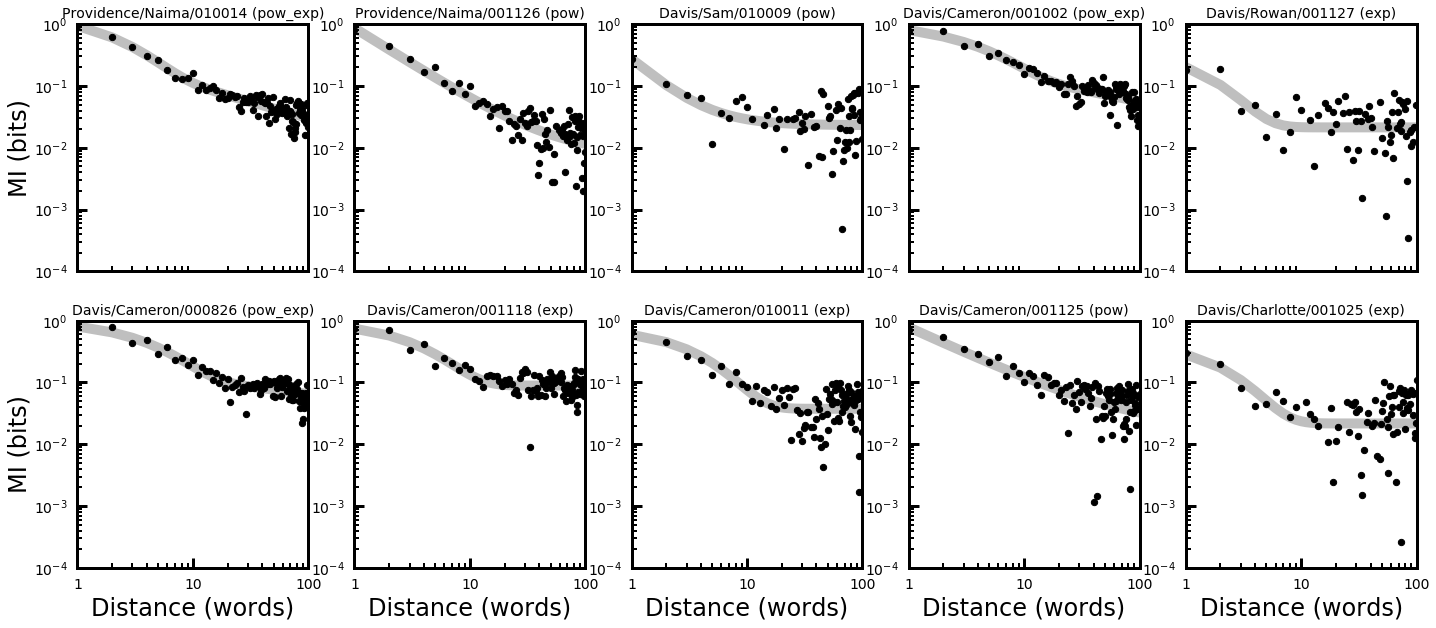

1 1.5


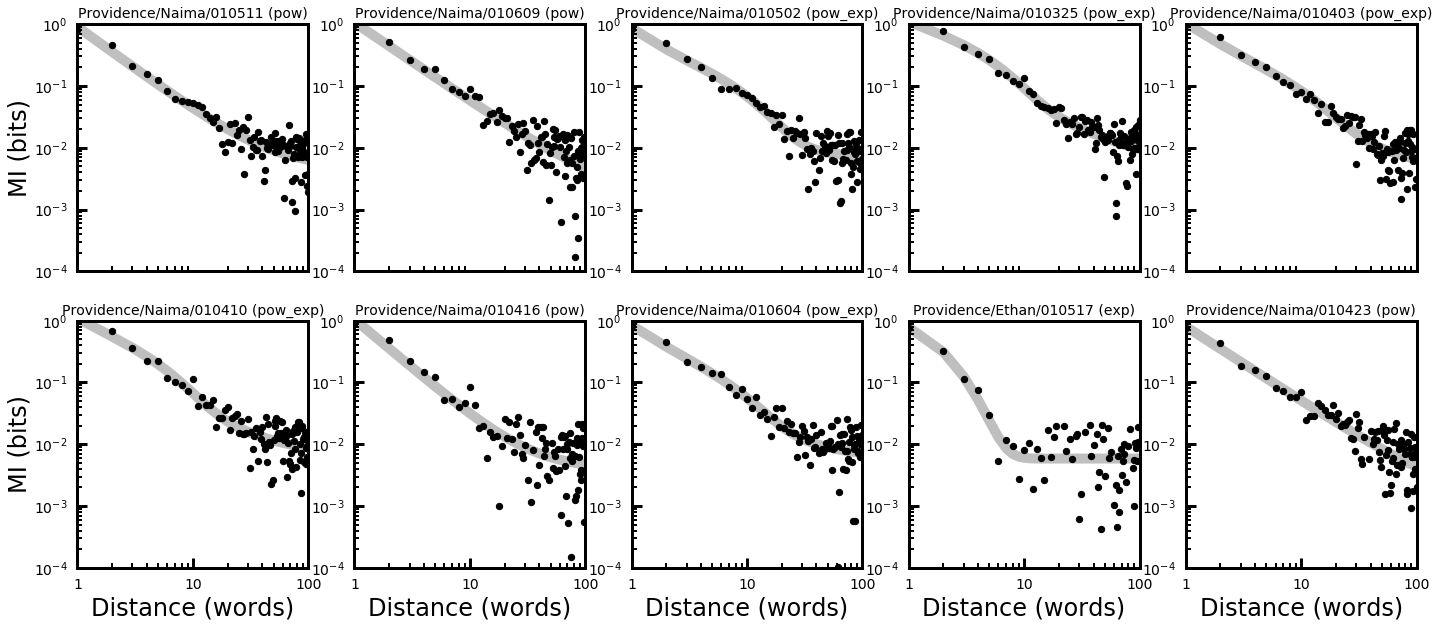

1.5 2


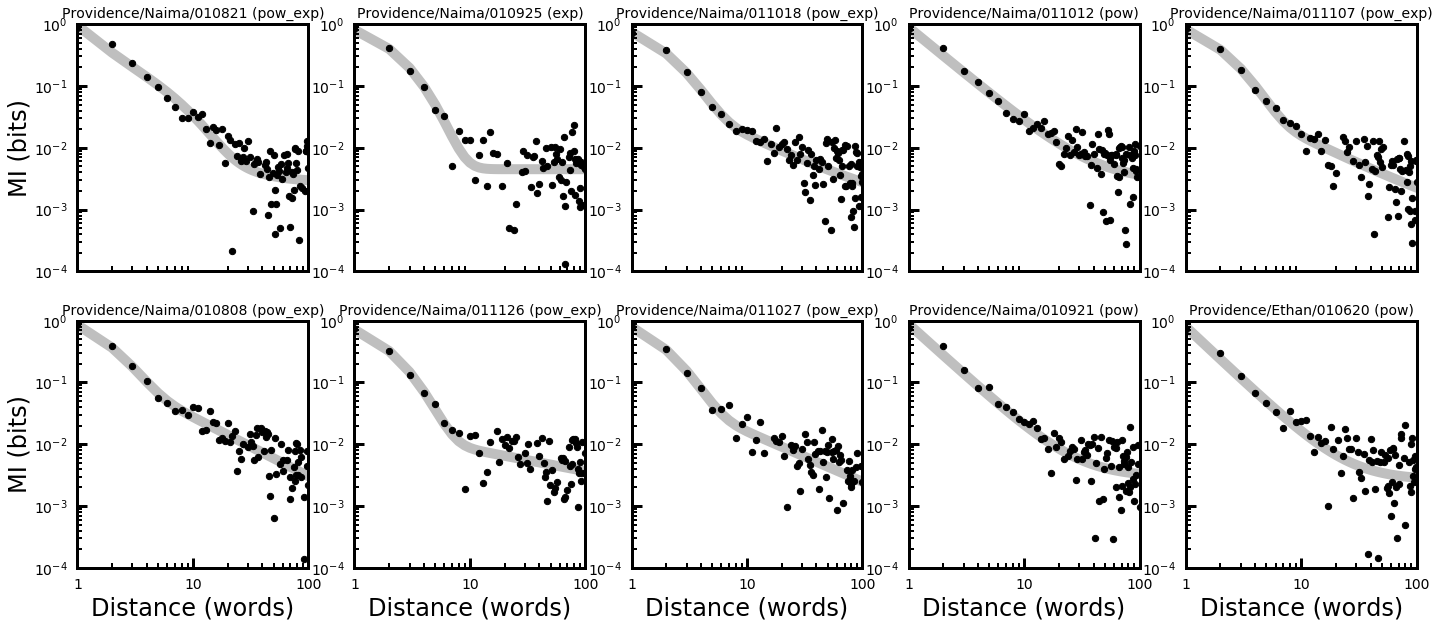

2 2.5


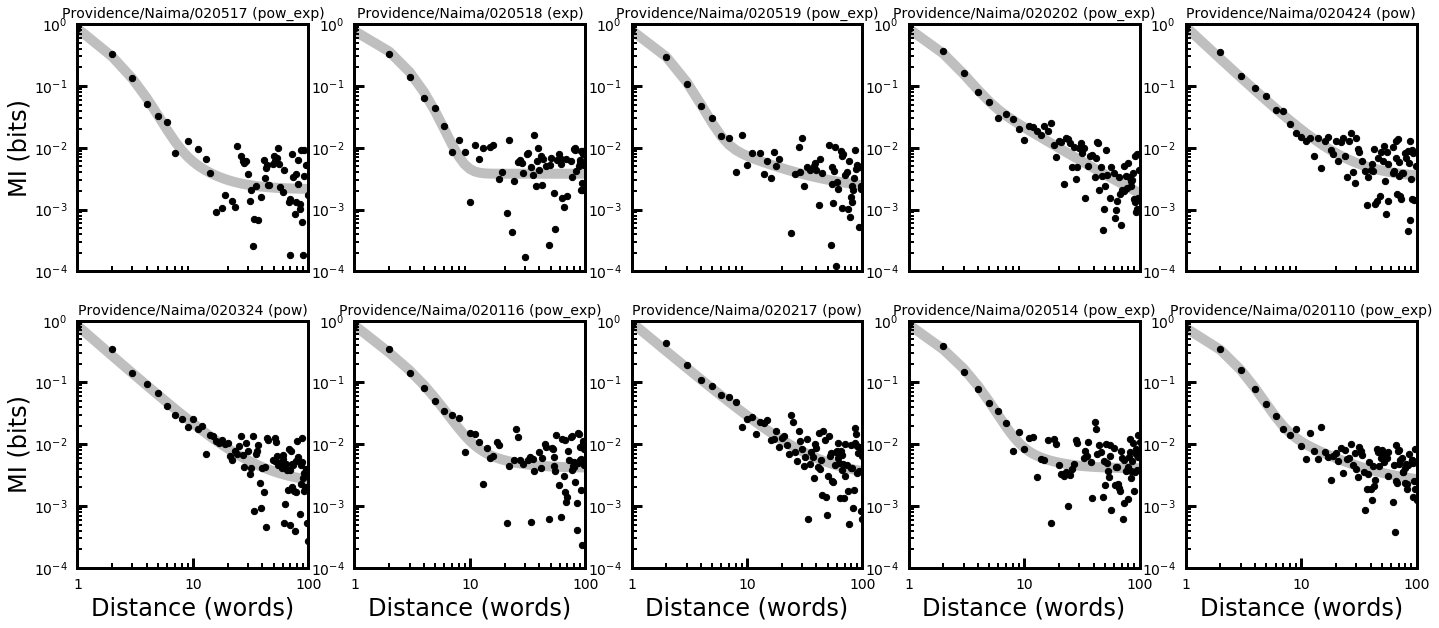

2.5 3


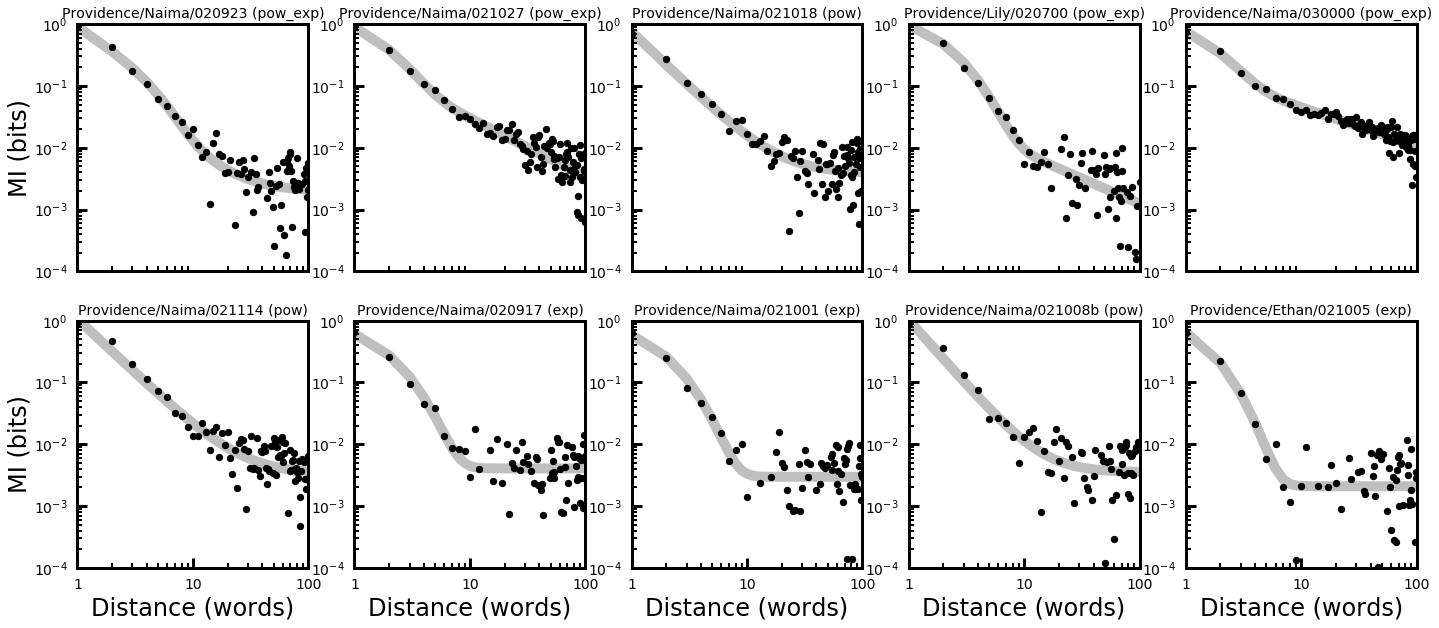

3 20


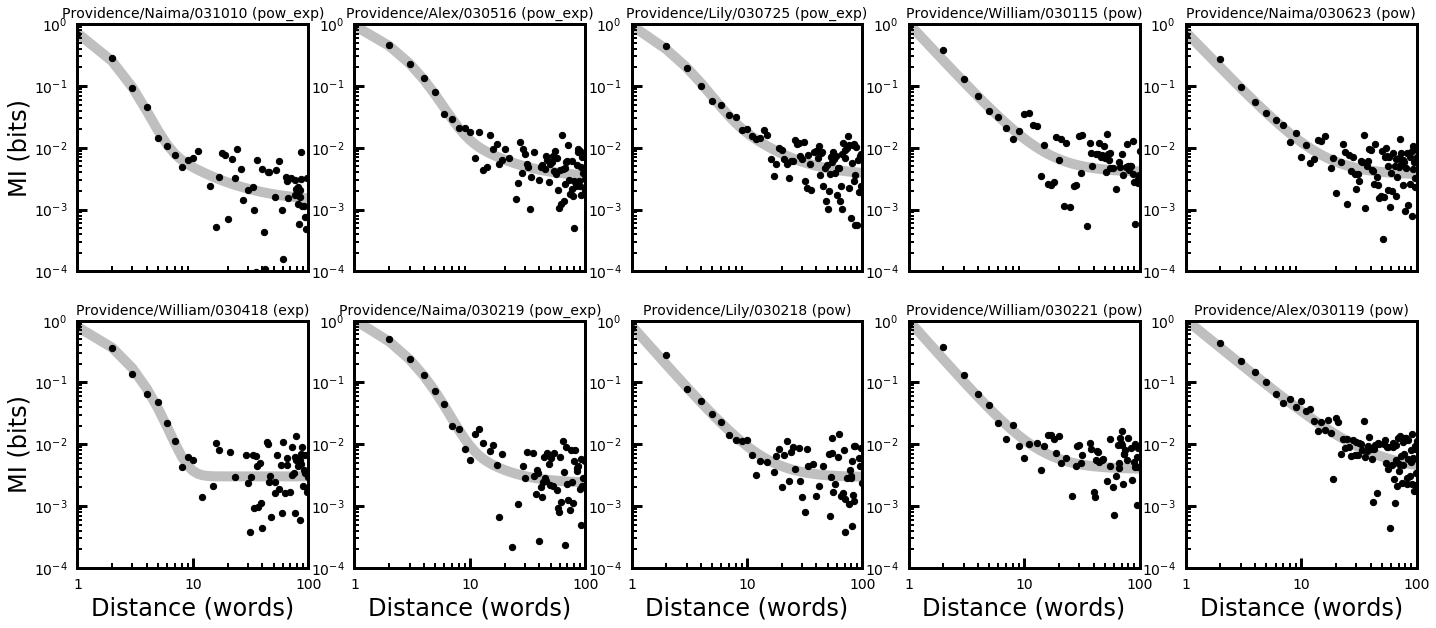

In [34]:
yoff=-.20

for [ac_low, ac_high] in age_cohorts:
    print(ac_low, ac_high)
    fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(24, 10))
    MI_DF_cohort = MI_DF[MI_DF.age_cohort_low == ac_low]
    for axi, (idx, row) in enumerate(MI_DF_cohort.iterrows()):
        ax = axs.flatten()[axi]

        color = "k"
        sig = np.array(row.MI - row.shuff_MI)
        distances = row.distances

        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                        sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
            
        
        if axi in [0, 5]:
            ax.set_ylabel("MI (bits)", labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff, 0.5)

        distances_model = np.logspace(0, np.log10(distances[-1]), base=10, num=1000)

        # plot real data
        ax.scatter(distances, sig, alpha=1, s=40, color=color)

        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)

        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)

        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

        # plot modelled data
        ax.plot(distances, y_model, alpha=0.25, lw=10, color=color)

        
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)  #
        ax.set_ylim([1e-4, 1])
        ax.tick_params(which="both", direction="in", labelsize=14, pad=10)
        ax.tick_params(which="major", length=10, width=3)
        ax.tick_params(which="minor", length=5, width=2)
        ax.set_xscale("log", basex=10)
        ax.set_yscale("log", basey=10)
        ax.set_xticks([])
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color("k")

        if axi in range(5, 10):
            ax.set_xticks([1,10,100])
            ax.set_xticklabels(['1','10','100'])
            ax.set_xlabel("Distance (phones)", labelpad=5, fontsize=24)
        
        ax.set_title(
            "{} ({})".format(
                "/".join(row.xml_loc.as_posix().split("/")[-3:])[:-4], row.bestfitmodel
            ),
            fontsize=14,
        )
    ensure_dir(FIGURE_DIR/ 'mi' / 'indv')
    #save_fig(FIGURE_DIR/ 'mi' / 'indv' /('phonbank_mi_longest_' + str(ac_low) + '_' + str(ac_high)))
    plt.show()

0.5 1


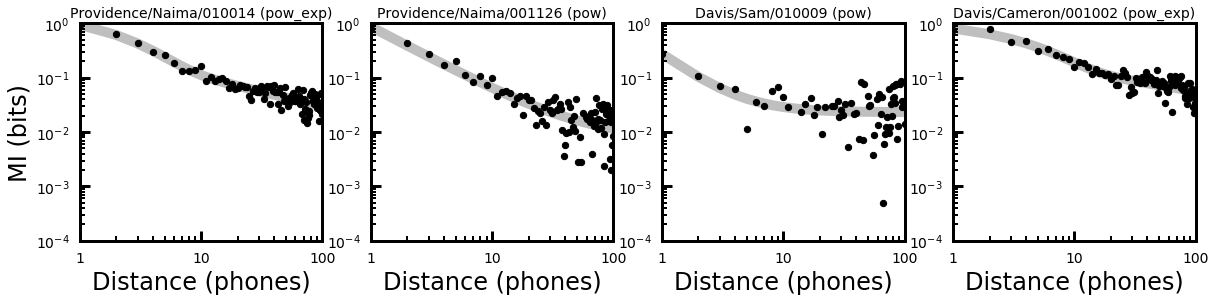

1 1.5


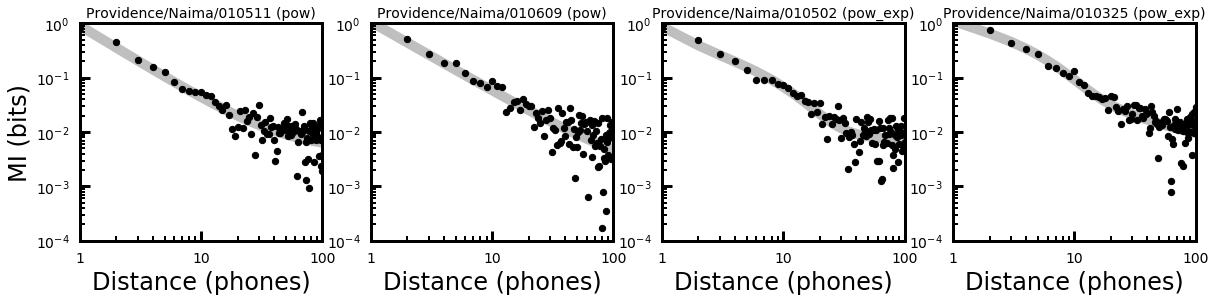

1.5 2


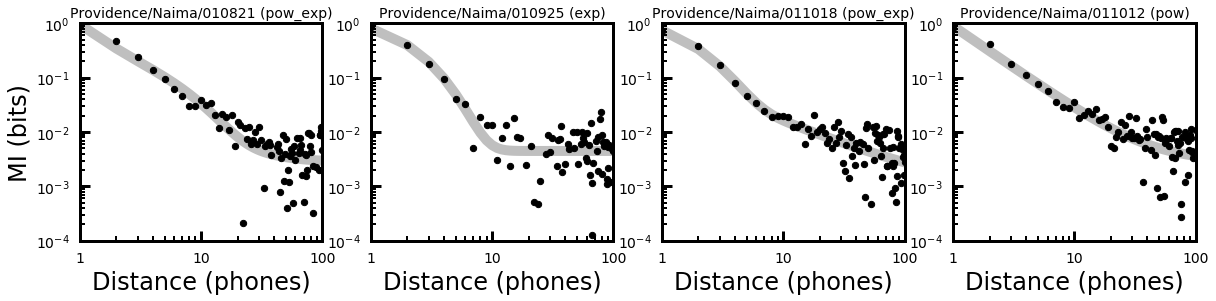

2 2.5


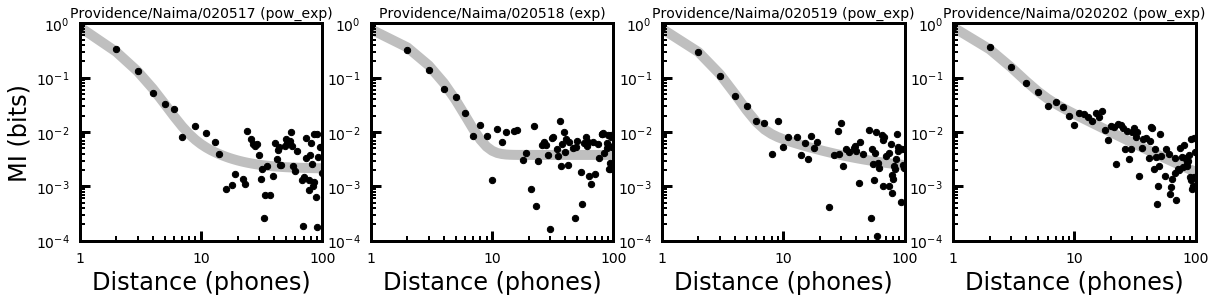

2.5 3


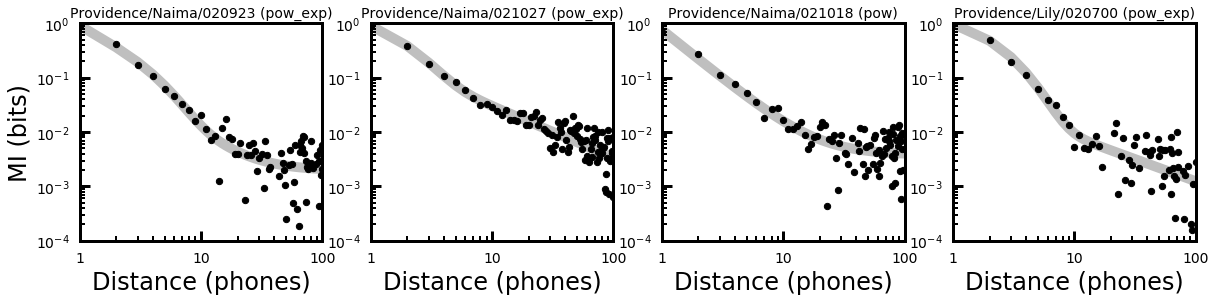

3 20


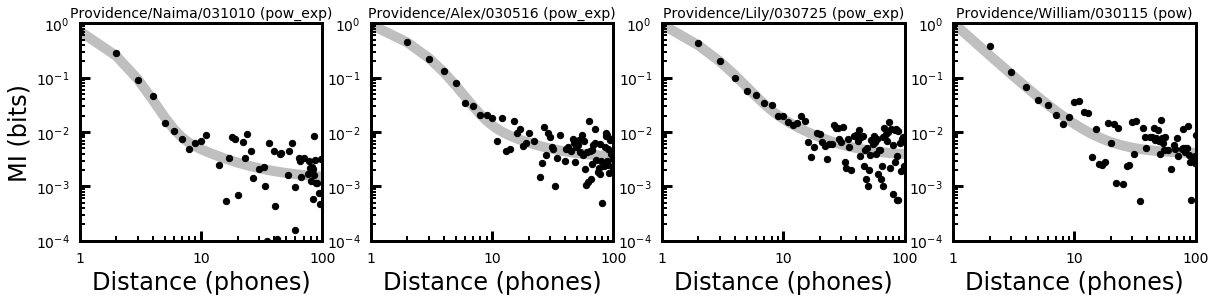

In [36]:
for [ac_low, ac_high] in age_cohorts:
    print(ac_low, ac_high)
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))
    MI_DF_cohort = MI_DF[MI_DF.age_cohort_low == ac_low]
    for axi, (idx, row) in enumerate(MI_DF_cohort[:4].iterrows()):
        ax = axs.flatten()[axi]

        color = "k"
        sig = np.array(row.MI - row.shuff_MI)
        distances = row.distances

        if axi in [0]:
            ax.set_ylabel("MI (bits)", labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff, 0.5)

        distances_model = np.logspace(0, np.log10(distances[-1]), base=10, num=1000)

        # plot real data
        ax.scatter(distances, sig, alpha=1, s=40, color=color)

        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)

        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)

        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

        # plot modelled data
        ax.plot(distances, y_model, alpha=0.25, lw=10, color=color)

        
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)  #
        ax.set_ylim([1e-4, 1])
        ax.tick_params(which="both", direction="in", labelsize=14, pad=10)
        ax.tick_params(which="major", length=10, width=3)
        ax.tick_params(which="minor", length=5, width=2)
        ax.set_xscale("log", basex=10)
        ax.set_yscale("log", basey=10)
        ax.set_xticks([])
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color("k")

        ax.set_xticks([1,10,100])
        ax.set_xticklabels(['1','10','100'])
        ax.set_xlabel("Distance (phones)", labelpad=5, fontsize=24)
        
        ax.set_title(
            "{} ({})".format(
                "/".join(row.xml_loc.as_posix().split("/")[-3:])[:-4], row.bestfitmodel
            ),
            fontsize=14,
        )
    ensure_dir(FIGURE_DIR/ 'mi' / 'indv')
    save_fig(FIGURE_DIR/ 'mi' / 'indv' /('phonbank_mi_longest_' + str(ac_low) + '_' + str(ac_high)))
    plt.show()